In [1]:
# Import the required libraries.
import os
import cv2
import json
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

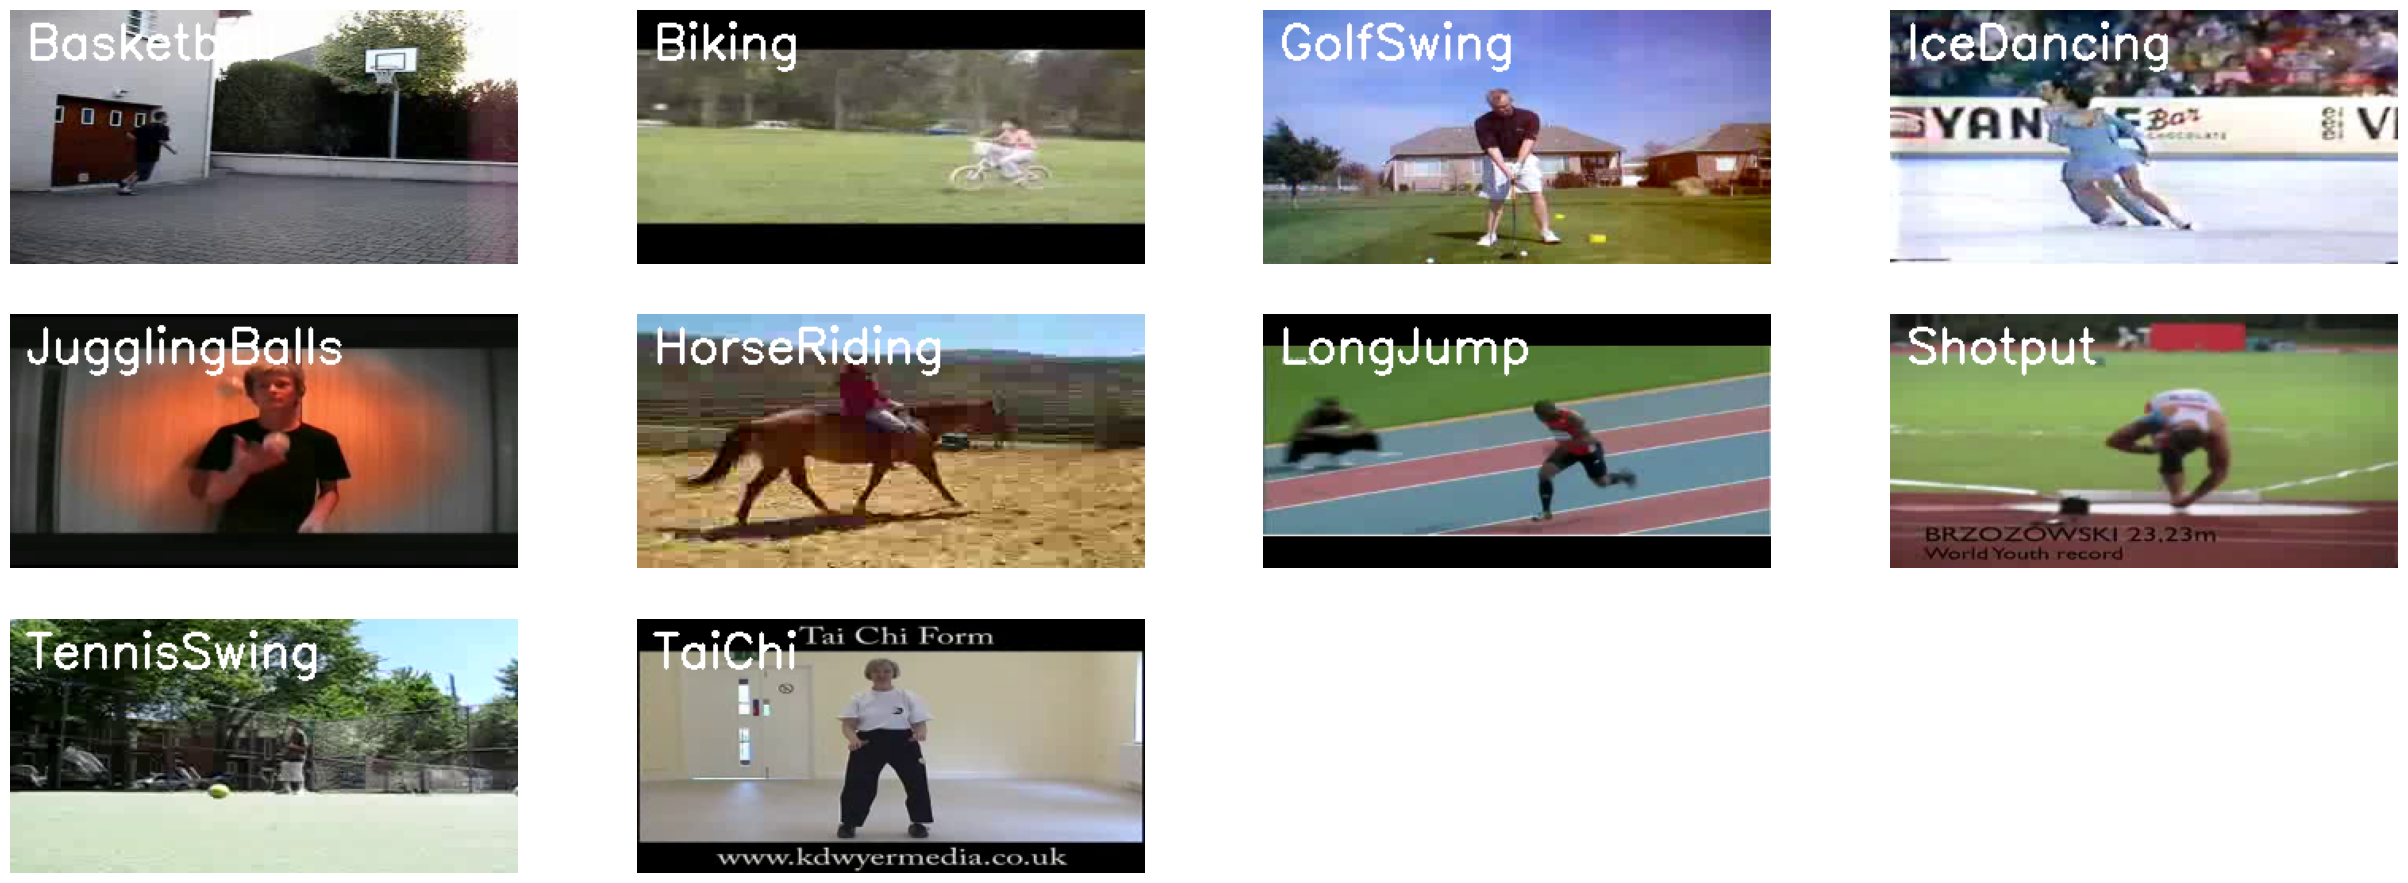

In [3]:
# Set the video directory path
video_directory =  r"D:\UCF-101"

# Specify the 20 classes
all_classes_names =["Walk-Front","Swing-SideAngle","Swing-Bench","SkateBoarding-Front","Run-Side","Lifting",
                    "Kicking-Side","Kicking-Front","Glof-Swing-Side","Golf-Swing"]
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 160, 320

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 60

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(31, 31))

# Iterate over the classes list.
for counter, class_name in enumerate(all_classes_names, 1):
    # Get a list of video files in the class directory.
    video_files = os.listdir(os.path.join(video_directory, class_name))
    
    # Randomly select a video file from the list.
    selected_video_file = random.choice(video_files)
    
    # Construct the full path to the selected video file.
    video_path = os.path.join(video_directory, class_name, selected_video_file)
    
    # Initialize a VideoCapture object to read from the video file.
    video_capture = cv2.VideoCapture(video_path)
    
    # Read the first frame of the video.
    _, frame = video_capture.read()
    
    # Release the VideoCapture object.
    video_capture.release()
    
    # Resize the frame to the specified height and width.
    resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    # Convert the frame from BGR to RGB format.
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(8, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# Show the plot.
plt.show()

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = r"D:\UCF-101"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = [
                "Basketball", "Biking", "GolfSwing", "IceDancing", "JugglingBalls", 
                "HorseRiding", "LongJump", "Shotput", "TennisSwing", "TaiChi"
               ]



In [5]:
def frames_extraction(video_path):
 

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
   
    video_reader.release()

    return frames_list

In [6]:
def create_dataset():


    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            
           
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [7]:

features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: Biking
Extracting Data of Class: GolfSwing
Extracting Data of Class: IceDancing
Extracting Data of Class: JugglingBalls
Extracting Data of Class: HorseRiding
Extracting Data of Class: LongJump
Extracting Data of Class: Shotput
Extracting Data of Class: TennisSwing
Extracting Data of Class: TaiChi


In [8]:

print(features)
print(labels)
one_hot_encoded_labels = to_categorical(labels)

[[[[[0.02745098 0.02745098 0.02745098]
    [0.05882353 0.05882353 0.05882353]
    [0.10980392 0.10980392 0.10980392]
    ...
    [0.03529412 0.04313725 0.0627451 ]
    [0.0745098  0.05098039 0.0745098 ]
    [0.06666667 0.07058824 0.09019608]]

   [[0.05490196 0.05490196 0.05490196]
    [0.08627451 0.08627451 0.08627451]
    [0.08627451 0.08627451 0.08627451]
    ...
    [0.07058824 0.11372549 0.12941176]
    [0.11764706 0.09411765 0.11764706]
    [0.01568627 0.00784314 0.02352941]]

   [[0.01568627 0.01568627 0.01568627]
    [0.03921569 0.03921569 0.03921569]
    [0.03137255 0.03137255 0.03137255]
    ...
    [0.01176471 0.02352941 0.03529412]
    [0.04313725 0.04705882 0.06666667]
    [0.07058824 0.08235294 0.10196078]]

   ...

   [[0.61960784 0.61176471 0.51764706]
    [0.61960784 0.61176471 0.51764706]
    [0.64313725 0.63529412 0.54117647]
    ...
    [0.58431373 0.59607843 0.50588235]
    [0.57254902 0.58431373 0.49411765]
    [0.53333333 0.54509804 0.45490196]]

   [[0.60392157 

In [9]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
print(features.shape)
print(labels.shape)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.05, shuffle = True, random_state = seed_constant)

(1391, 20, 64, 64, 3)
(1391,)


In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
   
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)


    plt.title(str(plot_name))

    plt.legend()

In [11]:
def create_LRCN_model():
    model = Sequential()
   
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [12]:

LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

In [13]:

plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
print(features_test.shape)
print(features_train.shape)
print(features.shape)
print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

(70, 20, 64, 64, 3)
(1321, 20, 64, 64, 3)
(1391, 20, 64, 64, 3)
(1391,)
(1321, 10)
(70, 10)
Epoch 1/70
264/264 [==============================] - 19s 58ms/step - loss: 2.1960 - accuracy: 0.1761 - val_loss: 2.1016 - val_accuracy: 0.2189
Epoch 2/70
264/264 [==============================] - 14s 52ms/step - loss: 1.8717 - accuracy: 0.3059 - val_loss: 1.8291 - val_accuracy: 0.3170
Epoch 3/70
264/264 [==============================] - 14s 52ms/step - loss: 1.6739 - accuracy: 0.4072 - val_loss: 1.7241 - val_accuracy: 0.3585
Epoch 4/70
264/264 [==============================] - 14s 52ms/step - loss: 1.5486 - accuracy: 0.4413 - val_loss: 1.4517 - val_accuracy: 0.4604
Epoch 5/70
264/264 [==============================] - 14s 52ms/step - loss: 1.3504 - accuracy: 0.5275 - val_loss: 1.3376 - val_accuracy: 0.5283
Epoch 6/70
264/264 [==============================] - 14s 52ms/step - loss: 1.1941 - accuracy: 0.5852 - val_loss: 1.3335 - val_accuracy: 0.5208
Epoch 7/70
264/264 [========================

In [15]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

3/3 [==============================] - 0s 63ms/step - loss: 0.3524 - accuracy: 0.9143


In [16]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

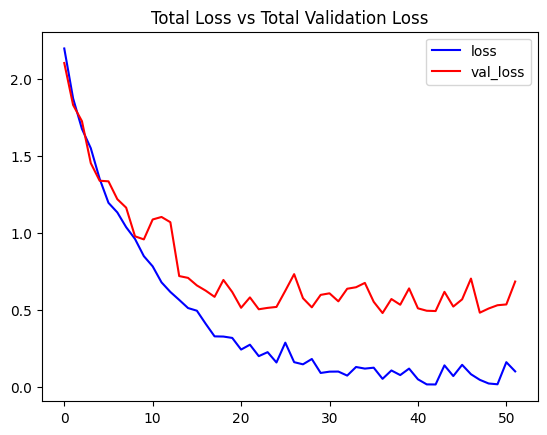

In [17]:

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

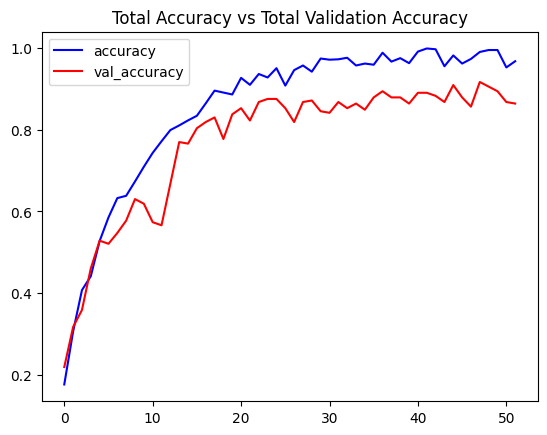

In [18]:

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))


    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''


    while video_reader.isOpened():


        ok, frame = video_reader.read() 

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

         
            predicted_class_name = CLASSES_LIST[predicted_label]

 
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)
    video_reader.release()
    video_writer.release()